In [1]:
raw_dat_dir = '/home/grace/Documents/python/ttc_inhalation/data/raw/'
processed_dat_dir = '/home/grace/Documents/python/ttc_inhalation/data/processed/'
interim_dat_dir = '/home/grace/Documents/python/ttc_inhalation/data/interim/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import os
import glob

### Process ToxVal.sdf through the various components from Toxtree

In [4]:
kroes = pd.read_csv(processed_dat_dir+'Kroes_results.csv')


In [5]:
kroes.columns

Index(['DTXSID', 'Kroes TTC decision tree',
       'Kroes TTC decision tree#explanation', 'cdk:Remark', 'cdk:Title',
       'name', 'SMILES'],
      dtype='object')

## Checked Kroes for null and removed them

In [8]:
kroes = kroes[~kroes['Kroes TTC decision tree'].isnull()]

In [9]:
kroes.shape

(4701, 7)

In [10]:
kroes.head()

,DTXSID,Kroes TTC decision tree,Kroes TTC decision tree#explanation,cdk:Remark,cdk:Title,name,SMILES
0,DTXSID3020596,Substance would not be expected to be a safety...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",NaN,DTXSID3020596,Ethylbenzene,CCC1=CC=CC=C1
1,DTXSID2021284,Substance would not be expected to be a safety...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",NaN,DTXSID2021284,Styrene,C=CC1=CC=CC=C1
2,DTXSID5020865,Negligible risk (low probability of a life-tim...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",NaN,DTXSID5020865,"4,4-Methylenebis(2-chloroaniline)",C1=C(CC2=CC=C(C(=C2)Cl)N)C=C(C(=C1)N)Cl
3,DTXSID7025180,Negligible risk (low probability of a life-tim...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",NaN,DTXSID7025180,"4,4-Diphenylmethane diisocyanate",C1=C(C=CC(=C1)N=C=O)CC2=CC=C(C=C2)N=C=O
4,DTXSID6022422,Negligible risk (low probability of a life-tim...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",NaN,DTXSID6022422,"4,4-Diaminobiphenyl methane",C1=C(C=CC(=C1)N)CC2=CC=C(C=C2)N


In [11]:
kroes['Kroes TTC decision tree'].unique()

array(['Substance would not be expected to be a safety concern',
       'Negligible risk (low probability of a life-time cancer risk greater than 1 in 10^6',
       'Risk assessment requires compound-specific toxicity data'],
      dtype=object)

In [12]:
exclusions = kroes[kroes['Kroes TTC decision tree'] == 'Risk assessment requires compound-specific toxicity data']

In [13]:
exclusions.shape

(218, 7)

In [14]:
q1y = exclusions[exclusions['Kroes TTC decision tree#explanation'] == 'Q1Y']

In [15]:
q1y.shape

(200, 7)

### Q1Y needs to be process through the new OPs filter as published in the Nelms et al 2019 paper

In [30]:
q1y.to_csv(processed_dat_dir+'Q1Y.csv')

In [16]:
q1y_wOPs = pd.read_csv(interim_dat_dir+'OPS_Q1Y.csv')

### Identifying actual OPs

In [17]:
OPs = q1y_wOPs[q1y_wOPs['Mark_OPs'] == 'Default Class 1']

In [18]:
OPs.shape

(70, 9)

### High potency carcinogens

In [19]:
highpotcarc = exclusions[exclusions['Kroes TTC decision tree#explanation'].str.contains('Q2Y,Q3Y')]

In [20]:
highpotcarc.head()
highpotcarc.shape

(18, 7)

## Substances presenting a gentox alert

In [22]:
gentox = kroes[kroes['Kroes TTC decision tree'].str.contains('Negli')]

In [40]:
gentox.head()
gentox.to_csv(interim_dat_dir+'Genetox_4Toxtree.csv')

In [23]:
gentox.shape

(1094, 7)

## Identifying carbamates

In [24]:
carbamates = pd.read_csv(interim_dat_dir+'Genetox_carbamates.csv')

In [25]:
carbamates = carbamates[carbamates['Mark_Carbamates'] == 'Default Class 1']
carbamates.shape

(17, 8)

## Identifying steroids

In [26]:
steroids = pd.read_csv(interim_dat_dir+'Genetox_steroids.csv')
steroids = steroids[steroids['Steroids'] == 'Default Class 1']
steroids.shape

(0, 8)

In [27]:
gentox.shape

(1094, 7)

### Anti-join to remove carbamates and steroid (in this case steroids were 0) from the gentox presenting substances

In [28]:
mer = gentox.merge(carbamates, how='left')
gentox_tot = mer[mer['Mark_Carbamates'].isnull()].drop(['Mark_Carbamates'], 1)

In [29]:
gentox_tot.shape

(1077, 7)

### Remove OPs from Q1Y set

In [30]:
mer2 = q1y.merge(OPs, how = 'left')
Q1Y_tot = mer2[mer2['Mark_OPs'].isnull()].drop(['Mark_OPs'],1)

In [31]:
Q1Y_tot.shape

(130, 8)

### Add steroids (if identified to the final set of exclusions Q1Y_tot

### Add High Pot Carc and exclusions together to return all substances that are not applicable for TTC

In [32]:
NA_4_TTC = pd.merge(Q1Y_tot, highpotcarc, on = 'DTXSID', how = 'outer')
NA_4_TTC.shape
#NA_4_TTC.to_csv(processed_dat_dir+'NA_4_TTC.csv')

(148, 14)

### Antijoin full Kroes set profiled and exclude all exclusions and genetox presenting substances

In [33]:
exclusions['exclusions'] = 'exclusions'
mer3 = kroes.merge(exclusions, how = 'left')

/home/grace/anaconda3/envs/clone_newchem/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
ttc1 = mer3[mer3['exclusions'].isnull()].drop(['exclusions'],1)

In [35]:
gentox['gentox'] = 'gentox'
mer4 = ttc1.merge(gentox, how = 'left')
ttc2 = mer4[mer4['gentox'].isnull()].drop(['gentox'],1)
ttc2.shape

/home/grace/anaconda3/envs/clone_newchem/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(3389, 7)

### Parsing out substances from NA for TTC, what have alerts for gentox to leave substances that can be processed for Cramer tree

In [89]:
ttc2.to_csv(interim_dat_dir+'TTC_4_Cramer.csv')

### Process substances based on their Cramer classes

In [4]:
cramer = pd.read_csv(interim_dat_dir+'Cramer_4Toxtree_results.csv')
cramer.head()

,Cramer rules,DTXSID,Kroes TTC decision tree,Kroes TTC decision tree#explanation,SMILES,cdk:Remark,cdk:Title,genetox,name,toxTree.tree.cramer.CramerTreeResult
0,Low (Class I),DTXSID3020596,Substance would not be expected to be a safety...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",CCC1=CC=CC=C1,NaN,DTXSID3020596,NaN,Ethylbenzene,"1N,2N,3N,5N,6N,7N,16N,17N,19N,23Y,27Y,28N,30N,18N"
1,Low (Class I),DTXSID2021284,Substance would not be expected to be a safety...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",C=CC1=CC=CC=C1,NaN,DTXSID2021284,NaN,Styrene,"1N,2N,3N,5N,6N,7N,16N,17N,19N,23Y,27Y,28N,30N,18N"
2,High (Class III),DTXSID1020431,Substance would not be expected to be a safety...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",C1=C(C=CC(=C1)Cl)Cl,NaN,DTXSID1020431,NaN,"1,4-Dichlorobenzene","1N,2N,3Y,4N"
3,High (Class III),DTXSID1021871,Substance would not be expected to be a safety...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",C1=C(C=CC(=C1)O)Cl,NaN,DTXSID1021871,NaN,4-Chlorophenol,"1N,2N,3Y,4N"
4,High (Class III),DTXSID5020029,Substance would not be expected to be a safety...,"Q1N,Alerts(genotoxic)Y,SA1_genN,SA2_genN,SA3_g...",C=CC#N,NaN,DTXSID5020029,NaN,Acrylonitrile,"1N,2Y"


In [5]:
figures_dir = '/home/grace/Documents/python/ttc_inhalation/reports/figures/'

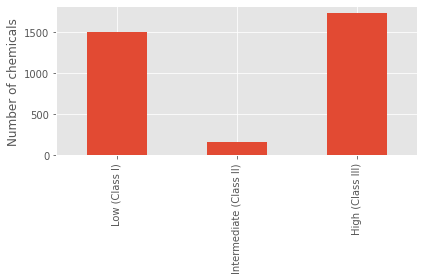

In [9]:
plt.style.use('ggplot')
cramer['Cramer rules'].value_counts(dropna = False).sort_index(ascending = False).plot.bar()
plt.ylabel('Number of chemicals')
plt.tight_layout()
plt.savefig(figures_dir+'Cramer_designations.png', dpi = 300)

In [38]:
cramer['Cramer rules'].value_counts(dropna = False)

High (Class III)           1726
Low (Class I)              1498
Intermediate (Class II)     165
Name: Cramer rules, dtype: int64

### Chemical properties

In [98]:
chem_prop = pd.read_csv(processed_dat_dir+'ToxVal_v7_pred_physchem.csv')

In [99]:
chem_prop.shape

(4703, 61)

In [102]:
mydict = {'DTXSID' : 'MoleculeID',
         'nbHBdAcc': 'nH_bond_acc', 
         'ndHBdDon' : 'nH_bond_don', 
         'MolWeight' : 'MW',
         'TopoPolSurfAir' : 'TPSA' ,
         'logP' : 'LogP_pred',
         'melting_point' : 'MP_pred',
         'boiling_point' : 'BP_pred',
         'log_vapour_pres' : 'LogVP_pred',
         'log_water_sol' : 'LogWS_pred',
         'log_henrys_law' : 'LogHL_pred',
         'logKOA' : 'LogKOA_pred',
         'pKa_acid' : 'pKa_a_pred',
         'pKa_base' : 'pKa_b_pred',
         'logD_55' : 'LogD55_pred',
         'logD_74' : 'LogD74_pred',
         'logOH' : 'LogOH_pred'}

In [104]:
myrev_dict = {v:k for k,v in mydict.items()}

In [105]:
chem_prop.rename(columns = myrev_dict, inplace = True)

In [106]:
chem_prop.head()

,DTXSID,MolWeight,nbAtoms,nbHeavyAtoms,nbC,nbO,nbN,nbAromAtom,nbRing,nbHeteroRing,...,Conf_index_pKa,logD_55,logD_74,AD_LogD,AD_index_LogD,Conf_index_LogD,logOH,AD_AOH,AD_index_AOH,Conf_index_AOH
0,DTXSID3020596,106.078250,18,8,8,0,0,6,1,0,...,0.358701,3.169397,3.169397,1,0.678181,0.596891,-10.977672,1,0.911374,0.817831
1,DTXSID2021284,104.062600,16,8,8,0,0,6,1,0,...,0.431938,2.928553,2.928553,1,0.656950,0.662520,-10.274111,1,0.853899,0.804606
2,DTXSID5020865,266.037754,29,17,13,0,2,12,2,0,...,0.688743,3.616479,3.707869,1,0.662210,0.684440,-10.847789,1,0.360898,0.568695
3,DTXSID7025180,250.074228,29,19,15,2,2,12,2,0,...,0.605524,2.818890,2.818906,1,0.386349,0.576067,-10.940394,0,0.194449,0.458024
4,DTXSID6022422,198.115698,29,15,13,0,2,12,2,0,...,0.848858,1.416549,1.524975,1,0.915255,0.840320,-10.528324,1,0.853005,0.845125


In [107]:
chem_prop.to_csv(processed_dat_dir+'ToxVal_v7_chem_prop.csv')